# Labb 3 – Kundsegmentering med KMeans + PCA
**Fokus:** diskussion och tolkning i oövervakad inlärning.

Ni jobbar på ett abonnemangsbolag (**Streamify**). Ni har beteendedata från de senaste 90 dagarna och vill ta fram **3–5 kundsegment** som marknad/produkt kan använda.

**Viktigt**
- Det finns ingen “target” och inget facit.
- Kluster är ett sätt att sammanfatta data, inte en absolut sanning.
- Målet är segment som är **rimliga, stabila och möjliga att beskriva**.

---

## Leverans till helklass
1) Vilket **K** valde ni och varför? (elbow + silhouette + rimligt antal segment)
2) Ge varje segment ett **namn** + 2–3 features som stöd.
3) Föreslå en åtgärd som Marknad/Produkt/Support kan rikta mot varje kundsegment

---
## Vad ni faktiskt ska göra (kort och tydligt)

1. **Kör igenom notebooken**  
   Kör notebooken **en cell i taget**. Stanna vid varje output och tolka/diskutera tillsammans.

2. **Välja antal segment (K)**  
   Ni tittar på *elbow* (inertia) och *silhouette* och väljer ett K som både ser rimligt ut och går att motivera.

3. **Tolka klustren med profiler**  
   Ni använder profil-tabellerna för att förstå vad som kännetecknar varje segment (både i verkliga enheter och som z-score).

4. **Döpa segmenten + föreslå en åtgärd**  
   Ge varje segment ett namn och föreslå en konkret sak som Marknad/Produkt/Support skulle kunna göra.

> Tänk: “Vi bygger en berättelse som går att använda”, inte “vi maxar en siffra”.


## Scenario: Streamify (abonnemangstjänst)
Streamify säljer ett abonnemang (99–699 kr/mån) med frivilliga tilläggstjänster.  
Ni vill förstå vilka “typer” av kunder ni har: användning, betalningsmönster, supportbehov, osv.

Ni får 8 numeriska features per kund (se nedan). Inga labels.

### Affärsmål (varför segment?)
Ledningen vill kunna svara på frågor som:
- Vilka kunder använder tjänsten **mycket** (och vad kännetecknar dem)?
- Vilka kunder verkar **pris-känsliga**?
- Finns det grupper som verkar ha **friktion** (mycket support / sena betalningar)?
- Vilka segment är rimliga att ha som “standard” i dashboards och kampanjer?

### Begränsning
Ni får *inte* skapa 20 segment. Marknad/Produkt/Support vill helst ha **3–5** som går att prata om utan att det blir för detaljerat.

## Features (vad betyder kolumnerna?)
| Feature | Vad betyder det? |
|---|---|
| `monthly_spend_sek` | Genomsnittlig månadskostnad (SEK) |
| `sessions_per_week` | Antal sessioner per vecka |
| `avg_session_min` | Genomsnittlig sessionslängd (minuter) |
| `tenure_months` | Hur länge kunden varit kund (månader) |
| `support_tickets_90d` | Supportärenden senaste 90 dagar |
| `discount_share` | Andel betalningar med rabatt (0–1) |
| `late_payments_12m` | Sena betalningar senaste 12 månader |
| `addons_count` | Antal tilläggstjänster |

In [75]:
# Importer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

## 1) Skapa syntetisk kunddata
Vi skapar data med:
- tydliga feature-namn (lätt att tolka)
- olika skalor (SEK vs 0–1)
- lite brus + några outliers
- lite saknade värden

In [76]:
NOISE_LEVEL = 0.8
OUTLIER_RATE = 0.02

def make_customer_data(n=2000, random_state=42, noise_level=1.0, outlier_rate=0.02):
    rng = np.random.default_rng(random_state)

    centers = np.array([
        [ 0.0,  0.0,  0.0],
        [ 3.0,  2.0, -0.5],
        [-3.0,  2.5,  1.0],
        [ 1.0, -3.0,  2.5],
    ])
    stds = np.array([1.0, 0.9, 1.0, 0.9]) * noise_level

    Z, _ = make_blobs(
        n_samples=n,
        centers=centers,
        cluster_std=stds,
        n_features=3,
        random_state=random_state
    )
    z = pd.DataFrame(Z, columns=["z0","z1","z2"])

    # features (med brus och olika skalor)
    monthly_spend = 399 + 130*z["z1"] + 90*z["z0"] + rng.normal(0, 55, n)
    monthly_spend = np.clip(monthly_spend, 99, None)

    sessions = 2.5 + 2.0*z["z0"] + rng.normal(0, 0.9, n)
    sessions = np.clip(sessions, 0, None)

    avg_session = 15 + 6.0*z["z0"] - 3.2*z["z2"] + rng.normal(0, 3.5, n)
    avg_session = np.clip(avg_session, 1, None)

    tenure = 18 + 11*z["z2"] + rng.normal(0, 7, n)
    tenure = np.clip(tenure, 0, None)

    support = 0.8 + 1.3*np.maximum(0, -z["z1"]) + 0.7*np.maximum(0, -z["z0"]) + rng.normal(0, 0.6, n)
    support = np.clip(np.round(support), 0, None)

    discount_share = 0.25 + 0.20*np.maximum(0, -z["z1"]) + rng.normal(0, 0.09, n)
    discount_share = np.clip(discount_share, 0, 1)

    late_payments = 0.6 + 1.0*np.maximum(0, -z["z2"]) + rng.normal(0, 0.7, n)
    late_payments = np.clip(np.round(late_payments), 0, None)

    addons = 1.0 + 1.0*np.maximum(0, z["z1"]) + 0.5*np.maximum(0, z["z0"]) + rng.normal(0, 0.5, n)
    addons = np.clip(np.round(addons), 0, None)

    X = pd.DataFrame({
        "monthly_spend_sek": monthly_spend,
        "sessions_per_week": sessions,
        "avg_session_min": avg_session,
        "tenure_months": tenure,
        "support_tickets_90d": support,
        "discount_share": discount_share,
        "late_payments_12m": late_payments,
        "addons_count": addons,
    })

    # Outliers
    m = int(outlier_rate * n)
    if m > 0:
        idx = rng.choice(n, size=m, replace=False)
        X.loc[idx, "monthly_spend_sek"] *= rng.uniform(2.0, 4.0, size=len(idx))
        X.loc[idx, "sessions_per_week"] *= rng.uniform(2.0, 3.0, size=len(idx))

    # saknade värden
    miss_idx = rng.choice(n, size=int(0.01*n), replace=False)
    X.loc[miss_idx, "avg_session_min"] = np.nan

    return X

X = make_customer_data(n=2000, random_state=RANDOM_SEED, noise_level=NOISE_LEVEL, outlier_rate=OUTLIER_RATE)
X.head(7)

,monthly_spend_sek,sessions_per_week,avg_session_min,tenure_months,support_tickets_90d,discount_share,late_payments_12m,addons_count
0,938.810594,9.423021,39.754417,13.117203,1.0,0.265865,1.0,4.0
1,293.372864,0.000000,1.000000,23.576901,4.0,0.330921,1.0,4.0
2,510.295876,2.852974,15.660956,24.676557,2.0,0.117496,-0.0,3.0
3,459.721783,0.000000,1.000000,37.706525,3.0,0.224323,-0.0,4.0
4,354.730203,0.000000,1.000000,7.272906,3.0,0.324624,1.0,4.0
5,212.337382,6.573821,13.860010,53.626891,2.0,0.644975,0.0,2.0
6,978.357050,9.052618,34.026566,10.193670,1.0,0.382060,-0.0,4.0


### Snabb översikt: saknade värden och skalor
Diskutera: vilka features har stora tal? Vilka ligger mellan 0 och 1?

**Varför finns saknade värden här?**  
I verkliga system blir vissa mätvärden ibland “tomma” (t.ex. om en loggning misslyckas).  
Här har vi medvetet lagt in ~1% saknade värden i `avg_session_min` för att ni ska se hur man hanterar det enkelt (median-imputering).

In [77]:
display(X.isna().mean().rename("missing_share"))
display(X.describe().T[["mean","std","min","max"]])

monthly_spend_sek      0.00
sessions_per_week      0.00
avg_session_min        0.01
tenure_months          0.00
support_tickets_90d    0.00
discount_share         0.00
late_payments_12m      0.00
addons_count           0.00
Name: missing_share, dtype: float64

,mean,std,min,max
monthly_spend_sek,495.977548,361.858110,99.0,3685.946977
sessions_per_week,4.021457,3.538999,0.0,27.974572
avg_session_min,15.983411,12.724863,1.0,48.155798
tenure_months,26.397252,15.140742,0.0,69.102785
support_tickets_90d,2.408000,1.739554,-0.0,7.000000
discount_share,0.408651,0.270681,0.0,1.000000
late_payments_12m,0.819500,0.741076,0.0,4.000000
addons_count,2.694000,1.520368,0.0,7.000000


## 2) Förbehandling: imputering + skalning
**Varför skalar vi? Diskutera:**  
Varför är det viktigt att skala datan innan vi kör KMeans?

Vi fyller saknade värden med median och skalar sedan.

In [78]:
X_imp = X.copy()
for col in X_imp.columns:
    X_imp[col] = X_imp[col].fillna(X_imp[col].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

## 3) Välj K: Elbow + Silhouette
### Elbow (inertia)
- Inertia minskar alltid när K ökar.
- Vi letar efter en punkt där förbättringen börjar **plana ut** (“armbåge”).

### Silhouette
- Högre silhouette betyder ofta tydligare separation.
- Men: silhouette är bara en indikator — segmenten måste också gå att **tolka**.

Vi börjar med graferna, och tittar sedan på tabellen med siffror.

**Kom ihåg:** Elbow letar efter “avtagande förbättring”, silhouette letar efter “separation”.  
Det viktigaste är fortfarande: *går segmenten att förklara och använda?*

In [79]:
K_MIN, K_MAX = 2, 8
rows = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    rows.append({
        "K": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_scaled, labels_k),
    })
scores = pd.DataFrame(rows)

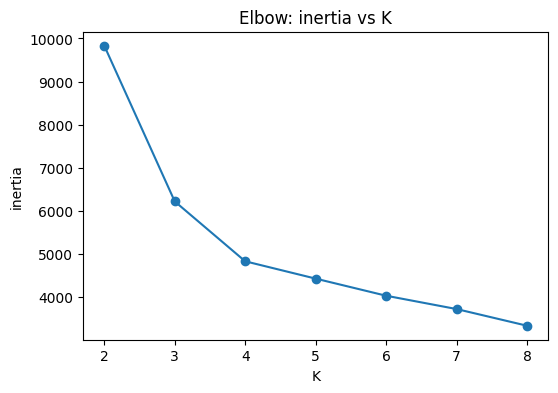

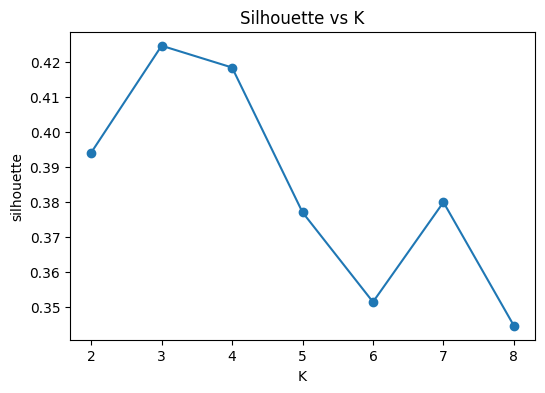

In [80]:
plt.figure(figsize=(6,4))
plt.plot(scores["K"], scores["inertia"], marker="o")
plt.title("Elbow: inertia vs K")
plt.xlabel("K"); plt.ylabel("inertia")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(scores["K"], scores["silhouette"], marker="o")
plt.title("Silhouette vs K")
plt.xlabel("K"); plt.ylabel("silhouette")
plt.show()

### Tabell: siffror för K
Använd tabellen som stöd när ni diskuterar graferna.

In [81]:
scores

,K,inertia,silhouette
0,2,9831.955637,0.394099
1,3,6216.380600,0.424653
2,4,4825.734092,0.418423
3,5,4423.291466,0.377053
4,6,4026.062865,0.351435
5,7,3716.693481,0.379941
6,8,3329.422242,0.344652


### Diskussionsruta: välj K (skriv ner er motivering)
- Var börjar inertia plana ut?
- Vilka K ser rimliga ut enligt silhouette?
- Är 3–5 segment en rimlig nivå för Streamify?

> Skriv ner: *Vi väljer K = __ för att …*

In [ ]:
K_CHOSEN = 1  # <-- ÄNDRA här (t.ex. 3, 4 eller 5)

kmeans = KMeans(n_clusters=K_CHOSEN, random_state=RANDOM_SEED, n_init=10)
labels = kmeans.fit_predict(X_scaled)

pd.Series(labels).value_counts().rename("cluster_size").sort_index()

0    496
1    499
2    504
3    501
Name: cluster_size, dtype: int64

## 4) Profil-tabeller: tolkning i original-skala + normaliserat (z-score)
Nu tolkar vi klustren. Vi vill först göra en **tolkning**, sen ge klustren **namn**.

Vi skriver ut två tabeller:
1) **Profil (original-skala)** – lätt att läsa i verkliga enheter (SEK, månader, antal)
2) **Profil (z-score)** – lätt att se vad som är högt/lågt jämfört med snittet

In [83]:
X_prof = X_imp.copy()
X_prof["cluster"] = labels

sizes = X_prof["cluster"].value_counts().sort_index().rename("n_customers")

# Original-skala (median)
profiles_raw = X_prof.groupby("cluster").median(numeric_only=True).join(sizes)
display(profiles_raw)

# Z-score profil (median)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_imp.columns)
X_scaled_df["cluster"] = labels

profiles_z = X_scaled_df.groupby("cluster").median(numeric_only=True).join(sizes)
display(profiles_z)

,monthly_spend_sek,sessions_per_week,avg_session_min,tenure_months,support_tickets_90d,discount_share,late_payments_12m,addons_count,n_customers
cluster,,,,,,,,,
0,397.293943,2.607310,15.112498,17.787139,1.0,0.284647,1.0,1.0,496
1,99.000000,4.511133,12.605890,45.338482,5.0,0.858308,1.0,1.0,499
2,931.207718,8.467471,34.347076,12.299790,1.0,0.252450,1.0,4.0,504
3,443.665911,0.000000,1.000000,29.797968,3.0,0.250769,1.0,3.0,501


,monthly_spend_sek,sessions_per_week,avg_session_min,tenure_months,support_tickets_90d,discount_share,late_payments_12m,addons_count,n_customers
cluster,,,,,,,,,
0,-0.272782,-0.399690,-0.067304,-0.568814,-0.809605,-0.458232,0.243626,-1.114482,496
1,-1.097327,0.138400,-0.265309,1.251324,1.490410,1.661624,0.243626,-1.114482,499
2,1.203066,1.256606,1.452102,-0.931327,-0.809605,-0.577210,0.243626,0.859217,504
3,-0.144600,-1.136610,-1.182099,0.224663,0.340402,-0.583420,0.243626,0.201317,501


**Hur läser man z-score-tabellen?**  
0 ≈ “genomsnittlig kund”. +1 ≈ “högre än normalt”. -1 ≈ “lägre än normalt”.

## 5) Hjälp: vad sticker ut i varje kluster?

Tabellen nedan visar vilka features som skiljer varje kluster mest från en “typisk kund” (medianen i hela datasettet, i z-score space).

- `delta_z` är **signerad**: **plus = högre än normalt**, **minus = lägre än normalt**
- `abs_delta_z` är storleken på avvikelsen (hur mycket det sticker ut)

Det här är tänkt som en “ledtråd”, inte facit.

In [84]:
# SIGNERAD avvikelse från “typisk kund” (i z-score space)
overall_z = X_scaled_df.drop(columns=["cluster"]).median(numeric_only=True)

delta_signed = profiles_z.drop(columns=["n_customers"]) - overall_z

rows = []
for c in profiles_z.index:
    # välj de 4 features som avviker mest (oavsett riktning)
    top_feats = delta_signed.loc[c].abs().sort_values(ascending=False).head(4).index
    for feat in top_feats:
        val = float(delta_signed.loc[c, feat])
        rows.append({
            "cluster": c,
            "feature": feat,
            "delta_z": val,
            "direction": "HIGH" if val > 0 else "LOW",
            "abs_delta_z": abs(val),
        })

top_features_tbl = (
    pd.DataFrame(rows)
    .sort_values(["cluster", "abs_delta_z"], ascending=[True, False])
)

top_features_tbl

,cluster,feature,delta_z,direction,abs_delta_z
0,0,addons_count,-0.657900,LOW,0.657900
1,0,support_tickets_90d,-0.575004,LOW,0.575004
2,0,tenure_months,-0.447577,LOW,0.447577
3,0,sessions_per_week,-0.280239,LOW,0.280239
4,1,discount_share,2.061268,HIGH,2.061268
5,1,support_tickets_90d,1.725011,HIGH,1.725011
6,1,tenure_months,1.372561,HIGH,1.372561
7,1,monthly_spend_sek,-0.889193,LOW,0.889193
8,2,avg_session_min,1.599885,HIGH,1.599885
9,2,monthly_spend_sek,1.411200,HIGH,1.411200


## Checkpoint: går segmenten att använda?
Innan ni döper segmenten – kolla detta:

**Bra tecken**
- Ni kan beskriva varje kluster med 1–2 meningar och peka på 2–3 features som stöd.
- Klusterstorlekarna känns rimliga (inga mikroskopiska kluster som bara är några få kunder).

**Varningsflaggor**
- Ett eller flera kluster känns som en “rest-hög” (svårt att hitta en tydlig profil).
- Kluster blir väldigt små (kan vara outliers eller att K är för högt).
- Segmenten ser nästan likadana ut i profilerna (K kan vara för högt eller datan saknar tydlig struktur).

Om ni har flera varningsflaggor: gå tillbaka och testa ett annat `K_CHOSEN` (t.ex. K±1) och jämför profilerna.

## 6) Uppgift: namnge segment
För varje kluster:
1) Ge ett **namn**.
2) Motivera med **2–3 features** (använd `profiles_raw`, `profiles_z`, `top_features_tbl`).
3) Vad skulle marknad/produkt/support kunna göra med segmentet?

Tips på format:
- Kluster 0: “...” (stöd: ..., ..., ...)
- Kluster 1: “...” (stöd: ..., ..., ...)

### Mini-mall (för varje segment)
- **Namn:**  
- **Bevis (2–3 features):**  
- **Åtgärd:** (en sak Marknad/Produkt/Support kan göra)  

Exempel på åtgärd: “skicka onboarding-mail”, “prioritera proaktiv support”, “erbjud uppgradering”, “erbjud rabatt”, osv.

## 7) PCA(2): visualisera klustren (intuition, inte facit)
PCA projicerar data till 2D så vi kan se något.

**Kom ihåg:** 2D kan dölja struktur som finns i fler dimensioner.  
Vi visar också hur mycket varians som fångas i 2D.

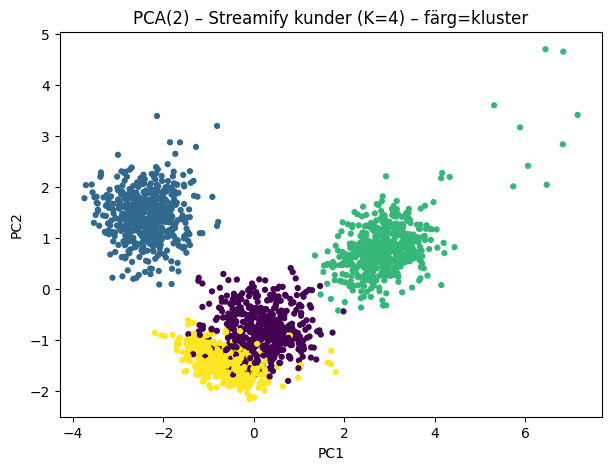

Förklarad varians i 2D: 0.691


In [85]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=12)
plt.title(f"PCA(2) – Streamify kunder (K={K_CHOSEN}) – färg=kluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Förklarad varians i 2D:", round(pca.explained_variance_ratio_.sum(), 3))

## 8) Stabilitet: ändras resultatet om vi byter random_state?
KMeans har slump (startpunkter). Om resultaten varierar mycket är klustren svårare att lita på.

Vi jämför silhouette över några seeds.

In [86]:
SEEDS = [0, 1, 2, 3, 4]
stab = []
for s in SEEDS:
    km = KMeans(n_clusters=K_CHOSEN, random_state=s, n_init=10)
    lab = km.fit_predict(X_scaled)
    stab.append({
        "seed": s,
        "silhouette": silhouette_score(X_scaled, lab),
        "inertia": km.inertia_
    })
pd.DataFrame(stab)

,seed,silhouette,inertia
0,0,0.418423,4825.734092
1,1,0.418423,4825.734092
2,2,0.418423,4825.734092
3,3,0.418423,4825.734092
4,4,0.418423,4825.734092


## Sammanfattning (för helklass)
När ni redovisar, försök få med:
1) **K-val:** elbow + silhouette + rimligt antal segment  
2) **Profiler:** namnge segment och peka på 2–3 features som stöd  
3) **Åtgärder:** Föreslå en åtgärd som Marknad/Produkt/Support kan rikta mot varje kundsegment
4) **Fallgropar:** En fallgrop om ni upptäckte någon (skalning, stabilitet, PCA(2) som förenkling, övertolkning)